In [1]:
import logging
import os
import numpy as np

from qcodes import Station, Measurement, load_or_create_experiment
from qcodes.tests.instrument_mocks import DummyInstrument
from qcodes.dataset.plotting import plot_dataset

from sim.data_providers import QcodesDataProvider
from sim.qcodes_mocks import MockDoubleQuantumDotInstrument

### Define the paths to the qcodes DBs containing simulation backing data

In [2]:
import nanotune
sim_db_root = os.path.join(
    os.path.dirname(os.path.abspath(nanotune.__file__)), "..", "data", "tuning")

char_db_path = os.path.join(sim_db_root, "device_characterization.db")
tune_db_path = os.path.join(sim_db_root, "dot_tuning_sequences.db")

for path in [char_db_path, tune_db_path]:
    if not os.path.exists(path):
        raise FileNotFoundError(path)

### Create the QuantumDotMockInstrument and Station

In [3]:
# Create the station and add the mock quantum dot instrument
exp = load_or_create_experiment("simtest")
station = Station()

qd_mock_instrument = MockDoubleQuantumDotInstrument()
station.add_component(qd_mock_instrument, name="qdmock")

# Get the simulator from the mock instrument for future use
qdsim = qd_mock_instrument.mock_device

In [4]:
station.snapshot()

{'instruments': {'qdmock': {'functions': {},
   'submodules': {},
   '__class__': 'sim.qcodes_mocks.MockDoubleQuantumDotInstrument',
   'parameters': {'IDN': {'__class__': 'qcodes.instrument.parameter.Parameter',
     'full_name': 'MockDoubleQuantumDotInstrument_IDN',
     'value': {'vendor': None,
      'model': 'MockDoubleQuantumDotInstrument',
      'serial': None,
      'firmware': None},
     'raw_value': {'vendor': None,
      'model': 'MockDoubleQuantumDotInstrument',
      'serial': None,
      'firmware': None},
     'ts': '2021-06-04 12:47:11',
     'instrument': 'sim.qcodes_mocks.MockDoubleQuantumDotInstrument',
     'instrument_name': 'MockDoubleQuantumDotInstrument',
     'inter_delay': 0,
     'post_delay': 0,
     'vals': '<Anything>',
     'label': 'IDN',
     'unit': '',
     'name': 'IDN'},
    'src': {'__class__': 'sim.qcodes_mocks.SimulationParameter',
     'full_name': 'MockDoubleQuantumDotInstrument_src',
     'value': 0.0,
     'raw_value': 0.0,
     'ts': '2021-

### Run a pinchoff measurement on the Left Plunger

In [6]:
# Create the data provider to use for the right plunger pinch-off measurement
# binding the sim.r_plunger pin as the input data provider
pinchoff_rp_data = QcodesDataProvider([qdsim.right_plunger], char_db_path, "GB_Newtown_Dev_3_2", 1206)

# Configure the simulator's drain pin to use the backing data
qdsim.drain.set_data_provider(pinchoff_rp_data)

In [7]:
# run the measurement
meas = Measurement(exp = exp, station = station)
meas.register_parameter(qd_mock_instrument.right_plunger)
meas.register_parameter(qd_mock_instrument.drain, setpoints=(qd_mock_instrument.right_plunger,))
meas.write_period = 2

n_points = 45
with meas.run() as datasaver:
    for voltage in np.linspace(0.0, -0.8, n_points):
        qd_mock_instrument.right_plunger.set(voltage)
        current = qd_mock_instrument.drain.get()
        datasaver.add_result((qd_mock_instrument.right_plunger, voltage), (qd_mock_instrument.drain, current))

    dataset = datasaver.dataset

Starting experimental run with id: 98. 


#### Plot the simulator's raw pinchoff backing data

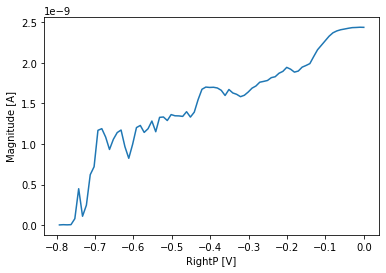

In [8]:
_ = pinchoff_rp_data.raw_data["Magnitude"].plot()

#### Plot the data measured through from the simulator

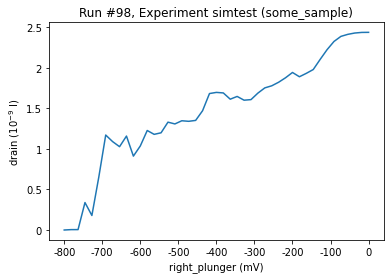

In [9]:
_ = plot_dataset(dataset)

### Run a 2D sweep to measure a charge state diagram

In [10]:
# create a data provider for charge-state data, using the left and Right Plunger gates as inputs
charge_state_data = QcodesDataProvider(input_providers = [qdsim.left_plunger, qdsim.right_plunger], db_path=tune_db_path, exp_name="GB_Newtown_Dev_1_1", run_id = 19)

# Configure the drain pin to use the charge state data provider as it's backing data
qdsim.drain.set_data_provider(charge_state_data)

In [11]:
# run the measurement
meas = Measurement(exp = exp, station = station)
meas.register_parameter(qd_mock_instrument.left_plunger)
meas.register_parameter(qd_mock_instrument.right_plunger)
meas.register_parameter(qd_mock_instrument.drain, setpoints=(qd_mock_instrument.left_plunger, qd_mock_instrument.right_plunger))
meas.write_period = 2

# Take 3x more samples than the raw data provides, to validate that interpolation is working
n_points = 150

with meas.run() as datasaver:
    for lp_v in np.linspace(0.0, -0.6, n_points):
        for rp_v in np.linspace(0.0, -0.5, n_points):
            qd_mock_instrument.left_plunger.set(lp_v)
            qd_mock_instrument.right_plunger.set(rp_v)
            current = qd_mock_instrument.drain.get()
            datasaver.add_result((qd_mock_instrument.left_plunger, lp_v), (qd_mock_instrument.right_plunger, rp_v), (qd_mock_instrument.drain, current))

    dataset = datasaver.dataset

Starting experimental run with id: 99. 


#### Plot the simulator's raw pinchoff backing data

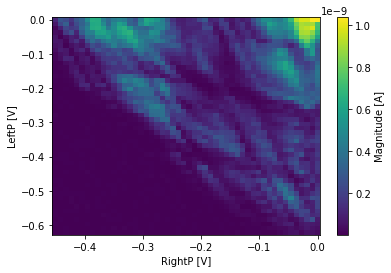

In [12]:
_ = charge_state_data.raw_data["Magnitude"].plot()

#### Plot the data measured through from the simulator

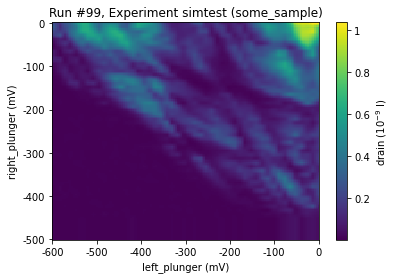

In [13]:
_ = plot_dataset(dataset)